# 멋진 작사가 만들기

RNN을 이용해서 여러 가사를 학습시킨 모델로 새로운 가사를 만들어보자.

## 0. 모듈 import

In [4]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import os, re 
import numpy as np
import tensorflow as tf

## 1. 데이터 다운로드


미리 준비된 데이터를 사용한다.

## 2. 데이터 읽어오기
glob로 모든 파일을 읽어서 하나의 리스트에 넣는다.

In [5]:
raw_corpus = []
txt_list = glob.glob(r'C:\Users\kwansu\Desktop\AIFFEL_LMS\E_04_\data\*')

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r", encoding='UTF8') as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

데이터가 잘 로드 됐는지 확인해보자.

In [6]:
print("Examples:\n", raw_corpus[:3])

Examples:
 ['Looking for some education', 'Made my way into the night', 'All that bullshit conversation']


## 3. 데이터 정제

### 정규화를 통한 전처리

정규화를 통해 필요없는 특수문자등을 제거하자.

그리고 너무 긴 문장은 노래가사에 어울리지 않을 수 있고,  
나머지 데이터의 0 padding이 너무 많아 지므로 15개이상의 토큰을 가질 경우 제거하자.

In [7]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

In [8]:
corpus = []
words = set()

for sentence in raw_corpus:
    if len(sentence.strip()) == 0: # 문자가 아예 없거나 공백으로 채워져있으면 제외
        continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    
    token = preprocessed_sentence.split()
    words.update(token)
    if len(token) > 15: # 문자가 15개를 넘으면 제외한다.
        continue
    
    corpus.append(preprocessed_sentence)
        
#corpus[0:10] # 전처리를 거친 데이터 10개만 출력
print(f"사용된 총 단어 개수 {len(words)}")

사용된 총 단어 개수 27621


## 4. 평가 데이터셋 분리

전처리된 데이터를 통해 학습 데이터셋과 테스트 데이터셋을 만들어보자.

### 데이터 토큰화

In [9]:
def tokenize(corpus, num_words):
    # num_words 만큼 단어를 기억할 수 있는 tokenizer를 생성
    # num_words 단어에 포함되지 못한 단어는 '<unk>' 대체
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, filters=' ', oov_token="<unk>")
    
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    return tensor, tokenizer

현재 모든 문장에서 사용된 총 단어 개수는 27621개이다.  
거의 사용되지 않는 단어를 제외하고, 많이 사용하는 순서대로  
절반쯤인 13000개의 단어를 저장하였다.

In [10]:
tensor, tokenizer = tokenize(corpus, 13000)

src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10:
        break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


가장 많이 사용된 글자는 pad와 start, end를 제외하면 i , the you 순이다.

### 데이터 분리

sklearn의 train_test_split을 사용해서 학습데이터와 테스트데이터로 분리하자.

In [11]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=7)

print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124960, 14)
Target Train: (124960, 14)


### Dataset만들기
문자가 토큰화되어 숫자로 바뀐 tensor를 이용하여 학습시킬 데이터 셋을 만들자.

In [12]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 13000개와, 여기 포함되지 않은 0:<pad>를 포함하여 13001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

# 검증 데이터셋 만들기
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.batch(BATCH_SIZE)

## 5. 인공지능 만들기
이제 준비된 데이터셋을 모델을 만들어 학습시켜보자.

### 모델 구성

In [13]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

### 하이퍼 파라미터 설정
데이터의 양이 많아진 만큼 임베딩 사이즈와 히든레이어를 좀 더 키웠다.

In [14]:
embedding_size = 512
hidden_size = 2048
epochs=20

In [15]:
#print(f"gpu를 사용 : {tf.test.is_gpu_available()}")

lyricist = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

lyricist.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
hist = lyricist.fit(train_dataset, epochs=20, validation_data=val_dataset)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Train for 488 steps, validate for 123 steps
Epoch 1/20
488/488 [==============================] - 327s 670ms/step - loss: 3.3833 - accuracy: 0.4926


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\kwansu\anaconda3\envs\tf_opencv\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\kwansu\AppData\Local\Temp/ipykernel_908/849086307.py", line 9, in <module>
    hist = lyricist.fit(train_dataset, epochs=20, validation_data=val_dataset)
  File "C:\Users\kwansu\anaconda3\envs\tf_opencv\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\kwansu\anaconda3\envs\tf_opencv\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 395, in fit
    total_epochs=1)
  File "C:\Users\kwansu\anaconda3\envs\tf_opencv\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 174, in run_one_epoch
    aggregator.aggregate(batch_outs)
  File "C:\Users\kwansu\anaconda3\envs\tf_opencv\lib\site-packages\tensorflow_core\python\keras

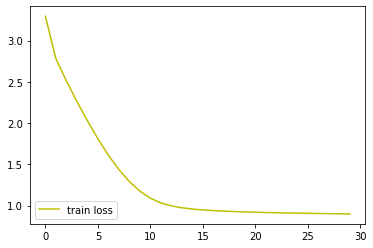

In [ ]:
save_model_path = os.getenv('HOME')+'/aiffel/lyricist/model/'
filename = f'lyricist_{embedding_size}_{hidden_size}_epochs.h5'

lyricist.save_weights(save_model_path + filename)
print(f"모델을 저장하였습니다. 위치 : {save_model_path}{filename}")

plt.plot(hsit.history['loss'], 'y', label='train loss')
#loss_ax.plot(hsit.history['val_loss'], 'r', label='val loss')
#acc_ax.plot(hsit.history['accuracy'], 'b', label='train acc')
#acc_ax.plot(hsit.history['val_accuracy'], 'g', label='val acc')
    
    
plt.legend(loc='upper left')
plt.legend(loc='lower left')
    
plt.show()

In [ ]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [ ]:
generate_text(lyricist, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m not gonna crack <end> '